#### Step 1. Data Preprocessing & Cleaning
✔ Load the dataset\
✔ Identify and handle missing values (true missing vs. "NA" meaning absence)\
✔ Convert incorrect data types (e.g., numeric features stored as objects)\
✔ Handle outliers and anomalies

In [94]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

train = pd.read_csv("home-data-for-ml-course\\train.csv")
test = pd.read_csv("home-data-for-ml-course\\test.csv")
train.columns = train.columns.str.strip()
test.columns = test.columns.str.strip()

##### we got the categories from the description of the dataset info offered to us.

In [95]:
#save the id
train_ID = train["Id"]
test_ID = test["Id"]

#drop ID duuuh..
train.drop("Id", axis = 1, inplace = True)
test.drop("Id", axis = 1, inplace = True)

#group features for preprocessing purpose.
train_categorical = [feature for feature in train.columns if train[feature].dtype == "object"] 

train_nominal = ["MSZoning", "Street", "Alley", "LandContour", "LotConfig", "Neighborhood", "Condition1", "Condition2", 
                    "BldgType", "HouseStyle", "RoofStyle", "RoofMatl", "Exterior1st", "Exterior2nd", "MasVnrType", "Foundation", "Heating",
                    "CentralAir", 'Electrical',"GarageType", "MiscFeature", "SaleType", "SaleCondition"]

train_ordinal = [ 'LotShape','Utilities','LandSlope','ExterQual','ExterCond','BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1',
                    'BsmtFinType2','HeatingQC','KitchenQual','Functional','FireplaceQu','GarageFinish','GarageQual',
                    'GarageCond','PavedDrive','PoolQC','Fence']

train_numerical = [feature for feature in train.columns if feature not in train_categorical + ['SalePrice']]

discrete_numerical_train = [ 'OverallQual','OverallCond','BsmtFullBath','BsmtHalfBath',
  'FullBath','HalfBath','BedroomAbvGr','KitchenAbvGr','TotRmsAbvGrd','Fireplaces','GarageCars','MoSold', "MSSubClass"] 

continuous_numerical_train = ['LotFrontage','LotArea','YearBuilt','YearRemodAdd','MasVnrArea','BsmtFinSF1','BsmtFinSF2',
                                  'BsmtUnfSF','TotalBsmtSF','1stFlrSF','2ndFlrSF','LowQualFinSF','GrLivArea','GarageYrBlt',
                                  'GarageArea','WoodDeckSF','OpenPorchSF','EnclosedPorch','3SsnPorch','ScreenPorch','PoolArea',
                                  'MiscVal','YrSold']

#### Step 2.Exploratory Data Analysis (EDA)
✔ Visualize target variable (SalePrice)\
Identify correlations between features and SalePrice\
Analyze categorical vs. numerical features\
Detect and handle outliers\

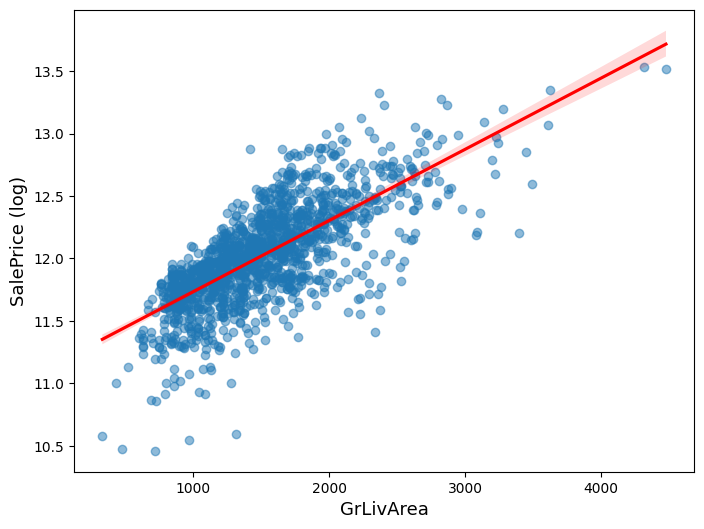

In [101]:
# Create figure and axis
fig, ax = plt.subplots(figsize=(8,6))

# Scatter plot with regression line
sns.regplot(x=train['GrLivArea'], 
            y=np.log(train['SalePrice']), 
            ax=ax, 
            scatter_kws={'alpha': 0.5},  # Adjust transparency of points
            line_kws={'color': 'red'})  # Set line color

# Labels
ax.set_xlabel("GrLivArea", fontsize=13)
ax.set_ylabel("SalePrice (log)", fontsize=13)

# Show the plot
plt.show()

#box plot, check it its used for geting outliers.

##### the freatures that we noticed have a strong correlation to the target value :
**1stFlrSF: First Floor square feet**\
**2ndFlrSF: Second floor square feet**\
**TotalBsmtSF : Total basement surface**


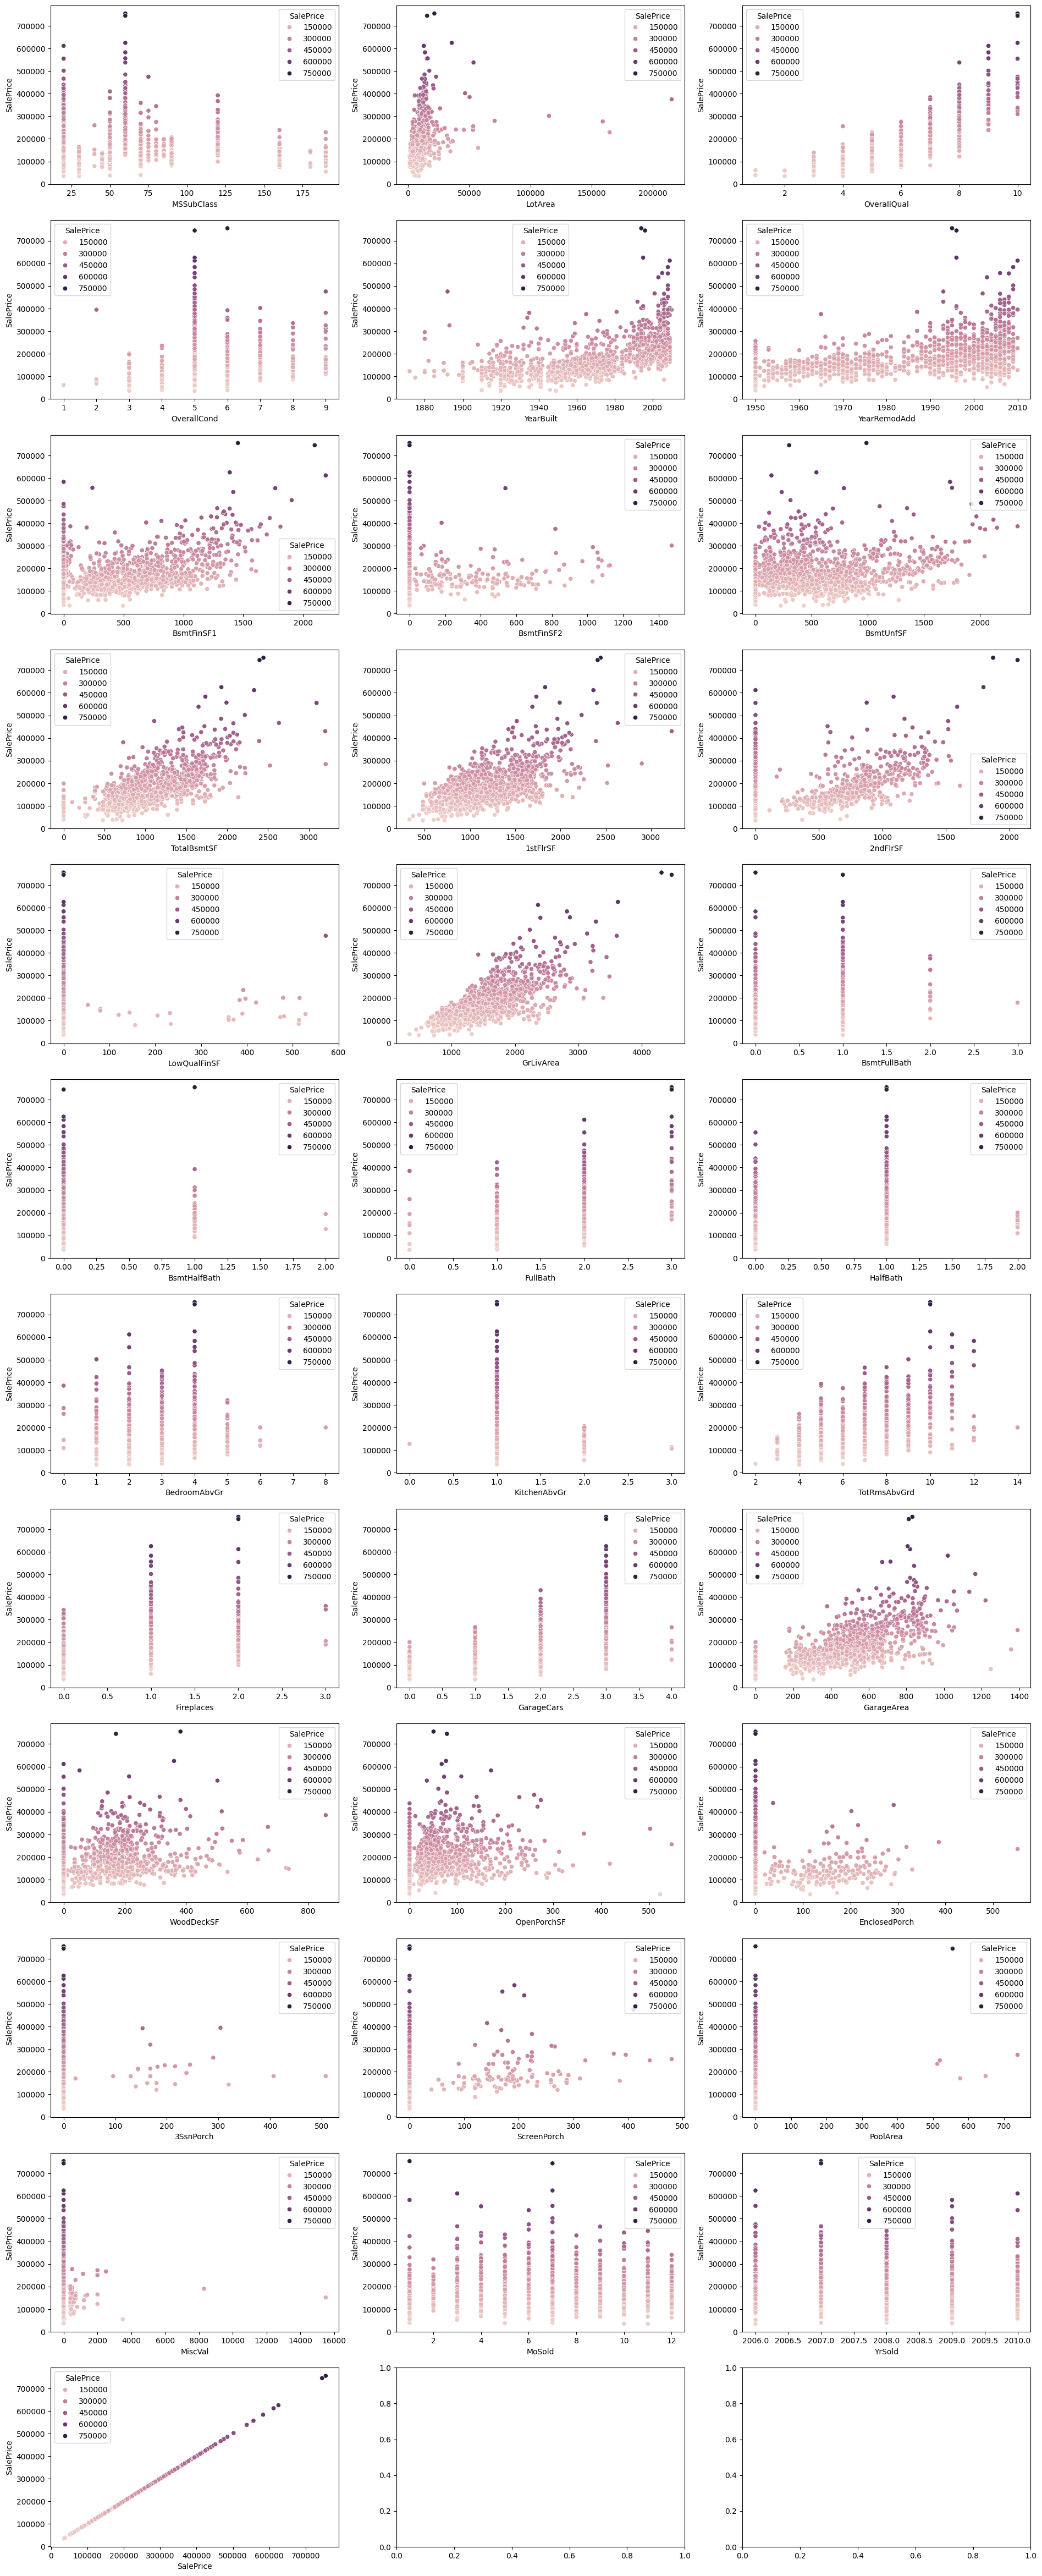

In [102]:
fig, ax = plt.subplots(12, 3, figsize=(23, 60))
for var, subplot in zip(train_numerical, ax.flatten()):
    sns.scatterplot(x=var, y='SalePrice',  data=train, ax=subplot, hue = 'SalePrice' )

dropped visually appearing outliers

In [103]:
train = train.drop(train[(train['BsmtFinSF1']>4000) & (train['SalePrice']<250000)].index)
train = train.drop(train[(train['GrLivArea']>4000) & (train['SalePrice']<250000)].index)

***Visualized the correlation between our target values [SalePrice] and all of our Features.***
- helps us understand our data better.
- show which features contributes more to the target value.
- show which features have the smallest effect incase we want to drop them.

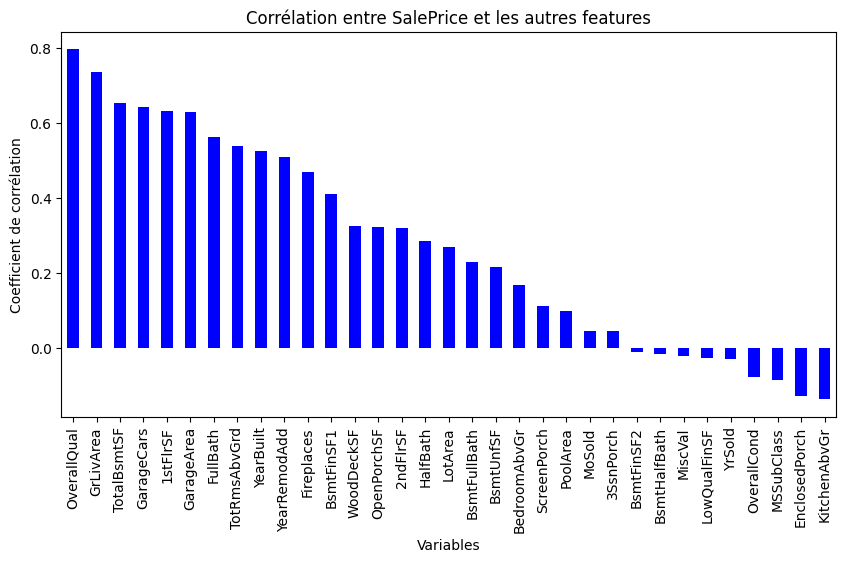

In [106]:
#train_numerical.corr()
train_numerical = train[[feature for feature in train.columns if feature not in train_categorical]]

corr = train_numerical.corr()['SalePrice'].sort_values(ascending=False)
plt.figure(figsize=(10,5))
corr[1:].plot(kind='bar', color='b')  # Exclut SalePrice (qui a une corrélation de 1 avec lui-même)
plt.title("Corrélation entre SalePrice et les autres features")
plt.ylabel("Coefficient de corrélation")
plt.xlabel("Variables")
plt.show()

##### Calculating **Correlation** and **Mutuel Information**
- using correlation matrix to detect redundency in features.
- drop, or merge the features with high correlation.
- When two features have high correlation, they carry similar information. This can lead to:
- ***Redundant features*** → Makes the model more complex without adding value.
- ***Multicollinearity*** → Some models (like Linear Regression) perform poorly when features are strongly correlated.

##### What to do?
- If two features are highly correlated (above 0.8-0.9), we usually remove one.
- If they have a meaningful relationship, we can combine them into a new feature (e.g., **"TotalSF"** = **"1stFlrSF"** + **"2ndFlrSF"** + **"TotalBsmtSF"**).\
***correlation measure only linear relationships between features***

so we will calculate ***Mutuel Information*** aswell to describe the relationship between our features
- ***MI*** measures how much information one feature provides about another
- If ***MI*** is high, the feature is useful for predicting the target (SalePrice).
- If ***MI*** is low, the feature doesn’t contribute much information.

In [110]:
corr_matrix = train_numerical.corr()
# sns.heatmap(corr_matrix, 
#             xticklabels=train_numerical.columns.values,
#             yticklabels=train_numerical.columns.values)
# Fill diagonal and upper half with NaNs
mask = np.zeros_like(corr_matrix, dtype=bool)
mask[np.triu_indices_from(mask)] = True
corr_matrix[mask] = np.nan
(corr_matrix
 .style
 .background_gradient(cmap='coolwarm', axis=None, vmin=-1, vmax=1)
 .highlight_null(color='#f1f1f1')  # Color NaNs grey
 .format(precision=2))

,MSSubClass,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
MSSubClass,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
LotArea,-0.14,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
OverallQual,0.03,0.09,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
OverallCond,-0.06,-0.00,-0.09,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
YearBuilt,0.03,0.01,0.57,-0.38,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
YearRemodAdd,0.04,0.01,0.55,0.07,0.59,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
BsmtFinSF1,-0.07,0.18,0.22,-0.04,0.25,0.12,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
BsmtFinSF2,-0.07,0.11,-0.06,0.04,-0.05,-0.07,-0.05,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
BsmtUnfSF,-0.14,-0.00,0.31,-0.14,0.15,0.18,-0.52,-0.21,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
TotalBsmtSF,-0.25,0.22,0.54,-0.17,0.40,0.29,0.47,0.11,0.44,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
